In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from scipy import stats
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20



In [3]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [4]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df = df[df.schedule_season > 1978]

In [5]:
df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

In [6]:
df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

In [7]:
df = df.fillna(value = 0)

In [8]:
df.index = range(0, len(df))

In [9]:
df.columns

Index(['schedule_date', 'schedule_season', 'schedule_week', 'team_home',
       'team_away', 'team_favorite_id', 'spread_favorite', 'over_under_line',
       'weather_detail', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'score_home', 'score_away', 'point_total',
       'over_under_result', 'score_difference', 'home_id', 'away_id',
       'home_favorite', 'favorite_covered', 'winning_team', 'losing_team',
       'home_wins', 'home_losses', 'home_ties', 'away_wins', 'away_losses',
       'away_ties', 'home_points_for', 'home_points_against',
       'away_points_for', 'away_points_against', 'h_games', 'a_games',
       'home_win_pct', 'away_win_pct', 'win_pct_diff', 'h_ppg', 'h_papg',
       'a_ppg', 'a_papg', 'home_pt_diff_pg', 'away_pt_diff_pg', 'pt_diff_pg',
       'home_exp_win_pct', 'away_exp_win_pct', 'home_win_pct_last_4',
       'away_win_pct_last_4', 'exp_win_difference', 'total_ppg',
       'total_points_against', 'last_four_difference'],
      dtype='o

In [10]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 19) & (df.schedule_season>2001)]

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



-4.417038000000001

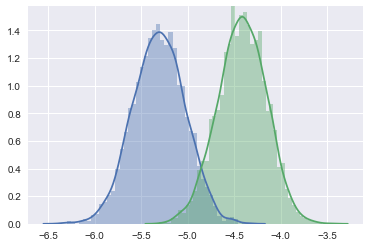

In [11]:
spread_samples = np.random.choice(week5_df.spread_favorite,25)
sample_means = spread_samples.mean()

def n_samples(arr,sample_size,n_samples):
    size = sample_size
    sample_means=[]
    
    for n in range(n_samples):
        sample_means.append(np.random.choice(arr,size).mean())
    
    return sample_means

x = n_samples(week5_df.spread_favorite,25,1000)

#sns.distplot(x)

ax1 = n_samples(week5_df.spread_favorite[(week5_df.spread_favorite>-12.5) & (week5_df.home_favorite==1)],100,5000)
ax2 = n_samples(week5_df.spread_favorite[(week5_df.spread_favorite>-12.5) & (week5_df.home_favorite==0)],100,5000)
sns.distplot(ax1)
sns.distplot(ax2)
sum(week5_df.spread_favorite<-12.5)/len(week5_df)
np.sum(ax1)/len(ax1)
np.sum(ax2)/len(ax2)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



7.375

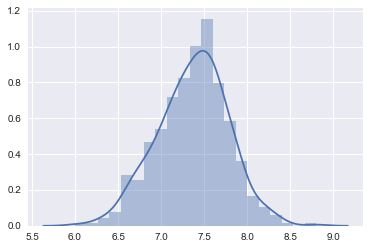

In [12]:
t = [9,9,9,9,9,9,1,4]
sns.distplot(n_samples(t,50,500))
np.sum(t)/len(t)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



(-10, 0)

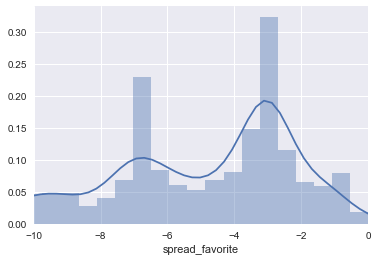

In [13]:
rw5 = np.random.choice(week5_df.spread_favorite,10)

ax = sns.distplot(week5_df.spread_favorite)
ax.set_xlim(-10,0)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



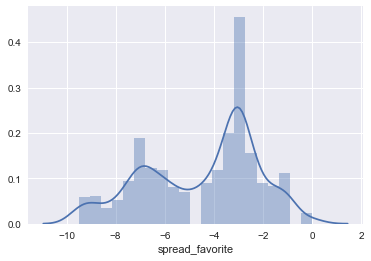

In [14]:
sns.distplot((reg_df.spread_favorite[reg_df['spread_favorite']>-10]))

In [15]:
reg_df['spread_favorite'].median()

-4.5

In [16]:
reg_df.columns

Index(['schedule_date', 'schedule_season', 'schedule_week', 'team_home',
       'team_away', 'team_favorite_id', 'spread_favorite', 'over_under_line',
       'weather_detail', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'score_home', 'score_away', 'point_total',
       'over_under_result', 'score_difference', 'home_id', 'away_id',
       'home_favorite', 'favorite_covered', 'winning_team', 'losing_team',
       'home_wins', 'home_losses', 'home_ties', 'away_wins', 'away_losses',
       'away_ties', 'home_points_for', 'home_points_against',
       'away_points_for', 'away_points_against', 'h_games', 'a_games',
       'home_win_pct', 'away_win_pct', 'win_pct_diff', 'h_ppg', 'h_papg',
       'a_ppg', 'a_papg', 'home_pt_diff_pg', 'away_pt_diff_pg', 'pt_diff_pg',
       'home_exp_win_pct', 'away_exp_win_pct', 'home_win_pct_last_4',
       'away_win_pct_last_4', 'exp_win_difference', 'total_ppg',
       'total_points_against', 'last_four_difference'],
      dtype='o

In [17]:
pivot = reg_df.pivot_table(index='spread_favorite', columns='favorite_covered',
                    aggfunc={'favorite_covered':len}, fill_value = 0)

In [18]:
pivot['row_total'] = 0
for index, row in pivot.iterrows():
    row.row_total = sum(row)

In [19]:
covered = pivot.favorite_covered[1]
no_cover = pivot.favorite_covered[0]
push = pivot.favorite_covered[2]

In [20]:
spreads = sorted(set(reg_df.spread_favorite))
x = np.array([spread for spread in spreads if spread > -15 and spread < 0])

In [21]:
y_covered = [covered[value]/pivot['row_total'][value] for value in x]
y_no_cover = [no_cover[value]/pivot['row_total'][value] for value in x]
y_push = [push[value]/pivot['row_total'][value] for value in x]

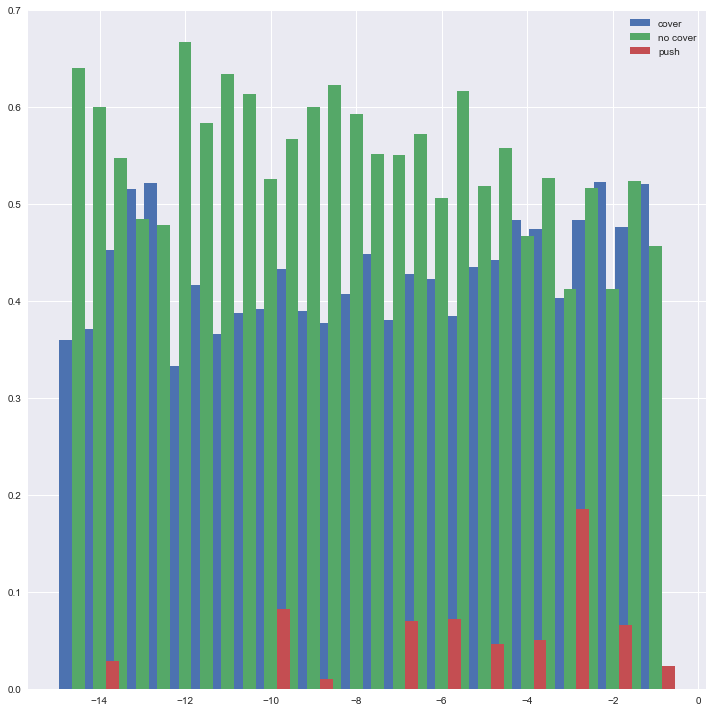

In [22]:
plt.figure(figsize = (10,10))
plt.bar(x-.3,y_covered, label = 'cover', width = .3)
plt.bar(x,y_no_cover, label = 'no cover', width = .3)
plt.bar(x+.3,y_push, label = 'push', width = .3)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=x,
    y=y_covered,
    name='Covered'
)
trace2 = go.Bar(
    x=x,
    y=y_no_cover,
    name='No Cover'
)

trace3 = go.Bar(
    x=x,
    y=y_push,
    name='Push'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [24]:
x = reg_df.corr()
x_dict = x['over_under_line'].to_dict()
sorted_dict = sorted(x_dict.items(), key = lambda x:x[1])
sorted_dict

[('weather_wind_mph', -0.27814438839587063),
 ('away_losses', -0.09181107897061887),
 ('home_losses', -0.08261468736976238),
 ('weather_humidity', -0.07296270790762051),
 ('favorite_covered', -0.06089438793056482),
 ('home_favorite', -0.04783828371692238),
 ('spread_favorite', -0.02676209774446886),
 ('schedule_week', -0.01590567168302309),
 ('h_games', -0.013207615072821465),
 ('a_games', -0.012557184401268516),
 ('home_ties', -0.009323614004445693),
 ('pt_diff_pg', -0.009019590703124431),
 ('exp_win_difference', -0.0027615639900368705),
 ('win_pct_diff', -0.0016914052458963243),
 ('last_four_difference', 0.0008104096904615186),
 ('score_difference', 0.004869988893768626),
 ('away_ties', 0.0285009517966309),
 ('home_wins', 0.06290691375775394),
 ('away_wins', 0.07262458799908296),
 ('away_points_against', 0.07738696378310155),
 ('home_points_against', 0.09375010316977914),
 ('away_win_pct_last_4', 0.10290023606164597),
 ('home_win_pct_last_4', 0.10353097316603686),
 ('home_win_pct', 0

In [25]:
reg_df

,schedule_date,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,weather_detail,weather_temperature,...,away_pt_diff_pg,pt_diff_pg,home_exp_win_pct,away_exp_win_pct,home_win_pct_last_4,away_win_pct_last_4,exp_win_difference,total_ppg,total_points_against,last_four_difference
5387,09/15/2002,2002,2,Atlanta Falcons,Chicago Bears,ATL,-2.5,45.0,DOME,72.0,...,4.000,-7.000,0.368063,0.719232,0.00,0.25,-0.351169,61.00,60.00,-0.25
5388,09/15/2002,2002,2,Baltimore Ravens,Tampa Bay Buccaneers,TB,-4.5,32.0,0,73.0,...,-6.000,3.000,0.180159,0.181480,0.00,0.00,-0.001321,27.00,36.00,0.00
5389,09/15/2002,2002,2,Carolina Panthers,Detroit Lions,CAR,-3.0,35.5,0,70.0,...,-28.000,31.000,0.819841,0.004504,0.25,0.00,0.815337,31.00,56.00,0.25
5390,09/15/2002,2002,2,Cleveland Browns,Cincinnati Bengals,CLE,-3.5,39.0,0,72.0,...,-28.000,27.000,0.458620,0.000068,0.00,0.00,0.458552,45.00,74.00,0.00
5391,09/15/2002,2002,2,Dallas Cowboys,Tennessee Titans,TEN,-3.5,37.5,0,79.0,...,3.000,-12.000,0.037651,0.666962,0.00,0.25,-0.629311,37.00,43.00,-0.25
5392,09/15/2002,2002,2,Indianapolis Colts,Miami Dolphins,PICK,0.0,47.0,DOME,72.0,...,28.000,-25.000,0.662566,0.995496,0.25,0.25,-0.332930,77.00,46.00,0.00
5393,09/15/2002,2002,2,Kansas City Chiefs,Jacksonville Jaguars,KC,-3.5,46.0,0,67.0,...,-3.000,4.000,0.541380,0.337434,0.25,0.00,0.203946,65.00,67.00,0.25
5394,09/15/2002,2002,2,Minnesota Vikings,Buffalo Bills,MIN,-3.5,49.0,DOME,72.0,...,-6.000,2.000,0.280768,0.246090,0.00,0.00,0.034678,54.00,64.00,0.00
5395,09/15/2002,2002,2,New Orleans Saints,Green Bay Packers,GB,-2.5,45.5,DOME,72.0,...,3.000,3.000,0.818520,0.631937,0.25,0.25,0.186584,63.00,54.00,0.00
5396,09/15/2002,2002,2,New York Jets,New England Patriots,NYJ,-1.0,41.0,0,75.0,...,16.000,-10.000,0.753910,0.986939,0.25,0.25,-0.233029,67.00,45.00,0.00


In [26]:
reg_df.describe()

,schedule_season,schedule_week,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,weather_humidity,score_home,score_away,point_total,...,away_pt_diff_pg,pt_diff_pg,home_exp_win_pct,away_exp_win_pct,home_win_pct_last_4,away_win_pct_last_4,exp_win_difference,total_ppg,total_points_against,last_four_difference
count,3841.000000,3841.000000,3841.000000,3841.000000,3841.00000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,...,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000
mean,2009.501953,9.651914,-5.419943,43.199948,59.83598,6.247852,65.391817,23.253840,20.697214,43.951054,...,0.306306,-0.581775,0.489658,0.512084,0.409691,0.427428,-0.022467,43.658961,43.625035,-0.017736
std,4.611360,4.684961,3.426142,4.713206,15.59030,5.457698,12.433429,10.322451,10.144719,14.066498,...,8.134176,11.366746,0.316927,0.318766,0.276171,0.275013,0.447746,8.307127,7.697963,0.361957
min,2002.000000,2.000000,-26.500000,30.000000,0.00000,0.000000,4.000000,0.000000,0.000000,3.000000,...,-42.000000,-52.000000,0.000000,0.000000,0.000000,0.000000,-0.998244,0.000000,0.000000,-1.000000
25%,2006.000000,6.000000,-7.000000,40.000000,49.00000,1.000000,64.000000,16.000000,13.000000,34.000000,...,-5.000000,-7.667000,0.193552,0.217616,0.250000,0.250000,-0.336171,38.300000,38.890000,-0.250000
50%,2010.000000,10.000000,-4.500000,43.500000,63.00000,6.000000,66.552000,23.000000,20.000000,43.000000,...,0.500000,-0.428000,0.486835,0.529577,0.500000,0.500000,-0.017929,43.500000,43.730000,0.000000
75%,2014.000000,14.000000,-3.000000,46.500000,72.00000,10.000000,68.000000,30.000000,27.000000,53.000000,...,5.571000,6.875000,0.781734,0.812959,0.500000,0.500000,0.289001,48.910000,48.500000,0.250000
max,2017.000000,17.000000,0.000000,60.000000,93.00000,40.000000,100.000000,62.000000,59.000000,106.000000,...,42.000000,54.000000,1.000000,1.000000,1.000000,1.000000,1.000000,83.000000,88.000000,1.000000


In [27]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
#     split = train_test_split(x, y)
#     X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
#     x = X_train
#     y = y_train
#     plt.scatter(x, y, s = s, alpha = alpha)
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [28]:
def regression_evaluation(target, X_list):
    target = target
    X = X_list 
    X2 = sm.add_constant(X)
    # model = sm.ols(formula = 'over_under_line ~ np.power(total_points_against, 1)', data = reg_df).fit()

    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    check = round(rmse_check(y_predicted, y_actual) - rmse)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    
    print('RMSE=' + str(rmse) + ', check =' + str(check))

In [29]:
def rmse_check(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val                                           #get the ^

# OVER/UNDER

# Variable 1 -Total Points Against

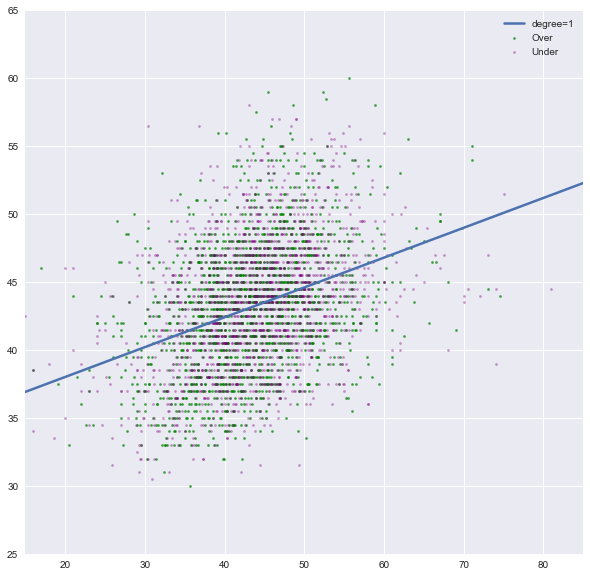

In [30]:
poly_regression((reg_df.total_points_against), reg_df.over_under_line, [1],15,85, 25, 65,10,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     566.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          6.17e-117
Time:                        10:23:18   Log-Likelihood:                -11140.
No. Observations:                3841   AIC:                         2.228e+04
Df Residuals:                    3839   BIC:                         2.230e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   33.6210 

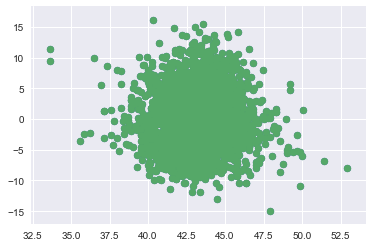

In [31]:
regression_evaluation(reg_df.over_under_line, reg_df.total_points_against)

# VARIABLE 2 -TOTAL PPG

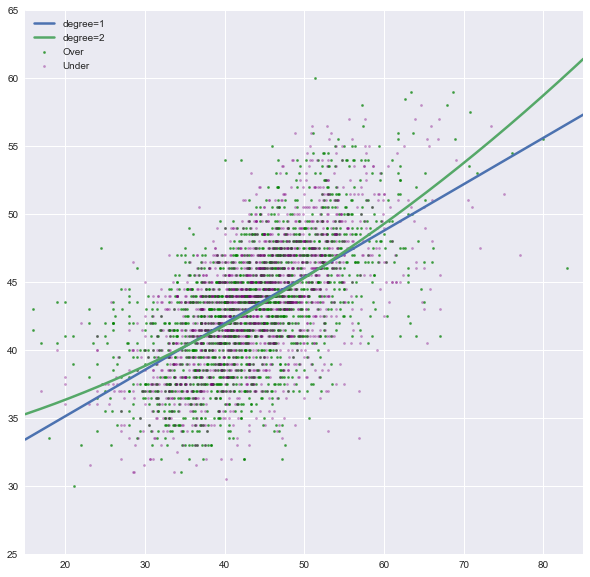

In [32]:
poly_regression((reg_df.total_ppg), reg_df.over_under_line, [1,2],15,85, 25, 65,10,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     2182.
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        10:23:19   Log-Likelihood:                -10540.
No. Observations:                3841   AIC:                         2.108e+04
Df Residuals:                    3839   BIC:                         2.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2891      0.325     87.052      0.0

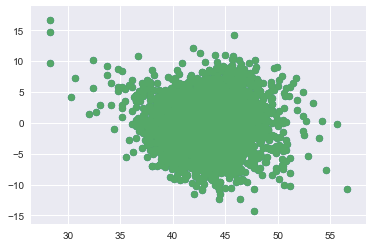

In [33]:
regression_evaluation(reg_df.over_under_line, (reg_df.total_ppg**1))

## VARIABLE 3 -WEATHER HUMIDITY

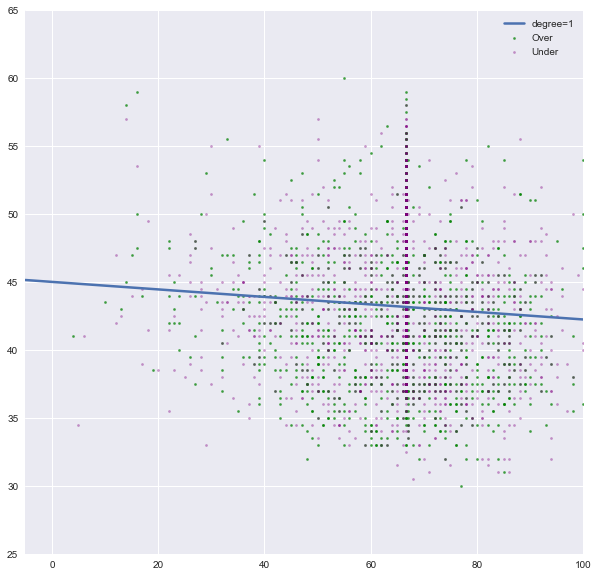

In [34]:
poly_regression(reg_df.weather_humidity, reg_df.over_under_line, [1],-5,100, 25, 65,-15,150)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     20.55
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           6.00e-06
Time:                        10:23:23   Log-Likelihood:                -11394.
No. Observations:                3841   AIC:                         2.279e+04
Df Residuals:                    3839   BIC:                         2.281e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               45.0086      0.406  

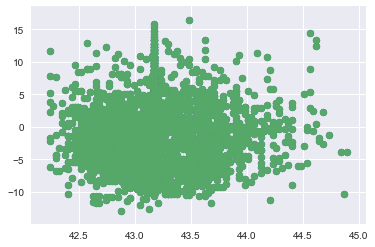

In [35]:
regression_evaluation(reg_df.over_under_line, (reg_df.weather_humidity**1))

# VARIABLE 4 - WIND MPH

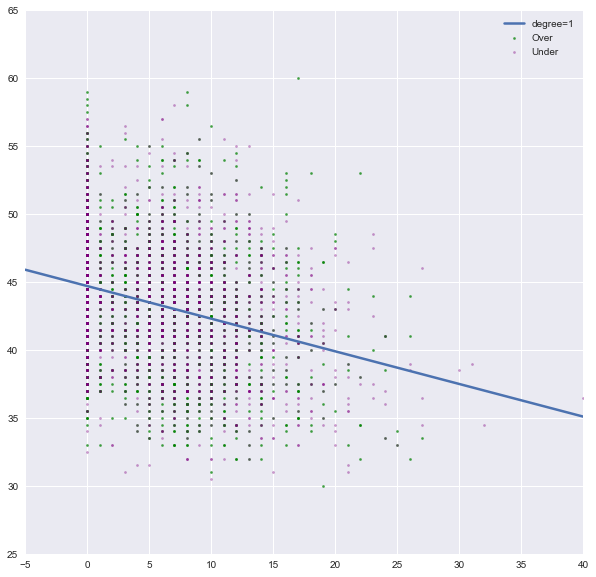

In [36]:
poly_regression(reg_df.weather_wind_mph, reg_df.over_under_line, [1],-5,40, 25, 65,-10,60)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     321.9
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           3.47e-69
Time:                        10:23:26   Log-Likelihood:                -11250.
No. Observations:                3841   AIC:                         2.250e+04
Df Residuals:                    3839   BIC:                         2.252e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               44.7007      0.111  

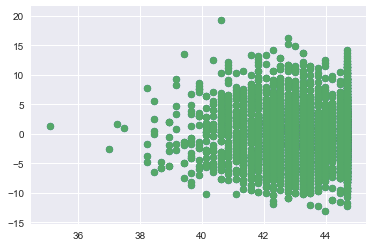

In [37]:
regression_evaluation(reg_df.over_under_line, (reg_df.weather_wind_mph**1))

# VARIABLE 5 - Weather Temp

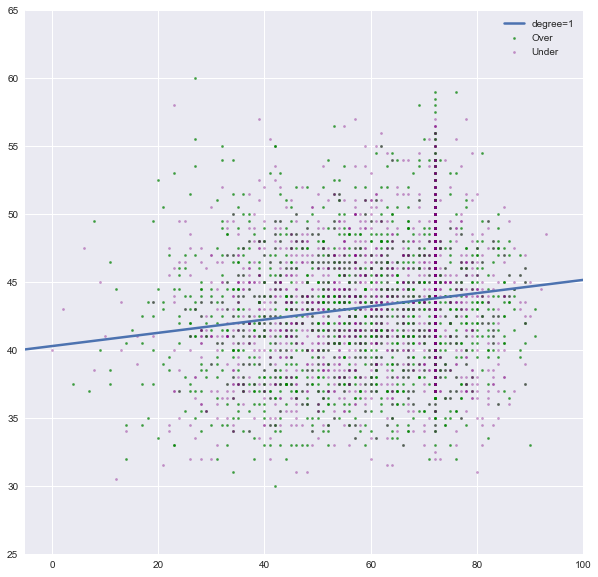

In [38]:
poly_regression(reg_df.weather_temperature, reg_df.over_under_line, [1],-5,100, 25, 65,-10,110)

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     102.4
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           9.20e-24
Time:                        10:23:28   Log-Likelihood:                -11354.
No. Observations:                3841   AIC:                         2.271e+04
Df Residuals:                    3839   BIC:                         2.272e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  40.2849    

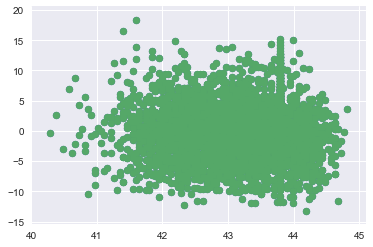

In [39]:
regression_evaluation(reg_df.over_under_line, (reg_df.weather_temperature**1))

# ALL VARIABLES FOR OVER/UNDER

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     957.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        10:23:30   Log-Likelihood:                -9848.5
No. Observations:                3841   AIC:                         1.971e+04
Df Residuals:                    3835   BIC:                         1.975e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.5255      0.570     32.486      0.0

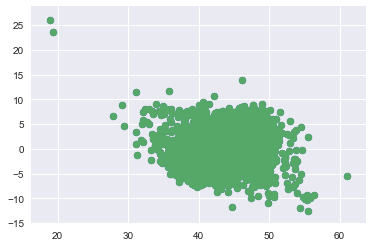

In [40]:
regression_evaluation(reg_df.over_under_line, reg_df[['weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']].values)

# SPREAD 

# Last 4 Games win %

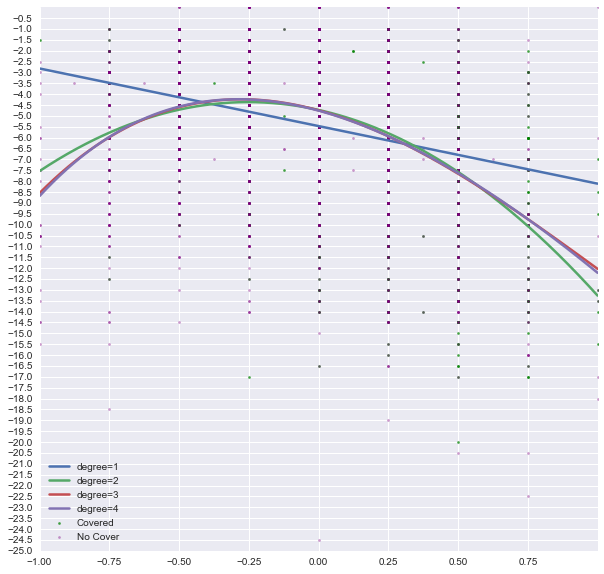

In [41]:
poly_regression(reg_df.last_four_difference, reg_df.spread_favorite, [1,2,3,4],-1,1, -25, 0,-1,1)
plt.yticks(np.arange(-25,0,.5))
plt.xticks(np.arange(-1,1,.25));

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     326.0
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           5.11e-70
Time:                        10:23:35   Log-Likelihood:                -10023.
No. Observations:                3841   AIC:                         2.005e+04
Df Residuals:                    3839   BIC:                         2.006e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.4669 

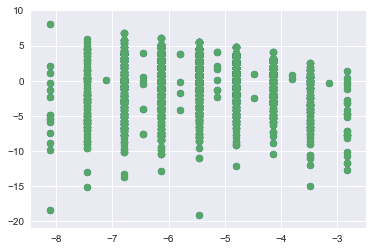

In [42]:
regression_evaluation(reg_df.spread_favorite, (reg_df.last_four_difference**1))

# WIN % DIFF REJECTED DUE TO LOW HIGH CORRELATION WITH EXP WINS

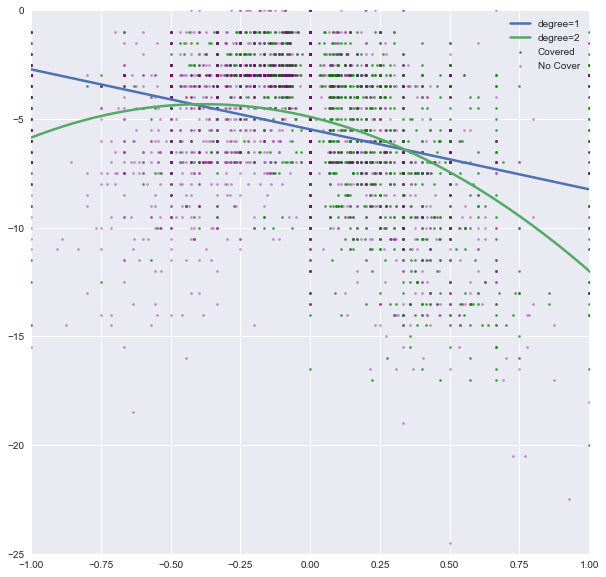

In [43]:
poly_regression(reg_df.win_pct_diff, reg_df.spread_favorite, [1,2],-1,1, -25, 0,-1,1)

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     394.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.17e-83
Time:                        10:23:37   Log-Likelihood:                -9991.7
No. Observations:                3841   AIC:                         1.999e+04
Df Residuals:                    3839   BIC:                         2.000e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.4802      0.053   -103.916   

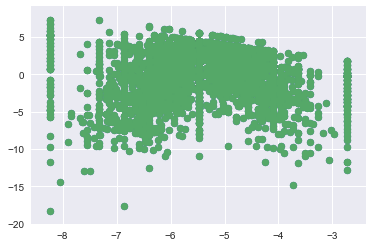

In [44]:
regression_evaluation(reg_df.spread_favorite, (reg_df.win_pct_diff**1))

# First Variable- Home Favorite

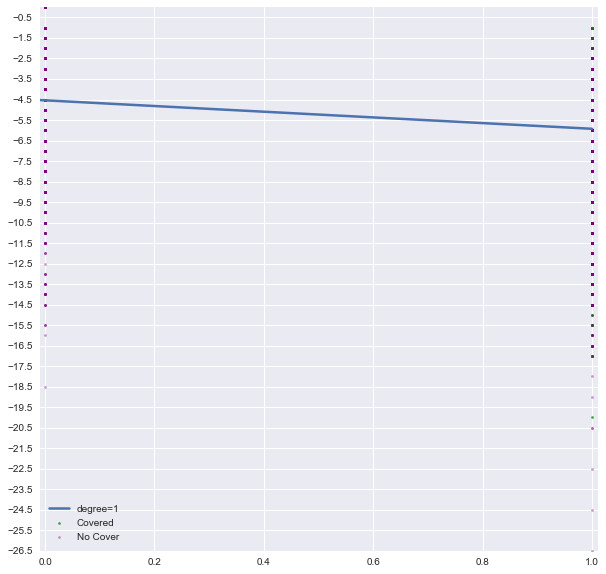

In [45]:
poly_regression(reg_df.home_favorite, reg_df.spread_favorite, [1],-.01,1.01, -25, 0,-1,1)
plt.yticks(np.arange(-26.5,0,1));

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     151.9
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           2.90e-34
Time:                        10:23:40   Log-Likelihood:                -10105.
No. Observations:                3841   AIC:                         2.021e+04
Df Residuals:                    3839   BIC:                         2.023e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.5399      0.090    -50.634

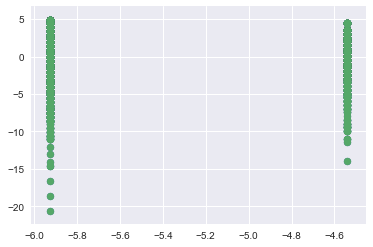

In [46]:
regression_evaluation(reg_df.spread_favorite, (reg_df.home_favorite**1))

In [47]:
# data = {"a":[2, 3, 5], "b":[2, 3, 5], "c":[2, 3, 5]}
# model = sm.ols(formula = 'a ~ np.power(b, 2) + b + c', data = reg_df).fit()

# SECOND VARIABLE - Exp Win Difference

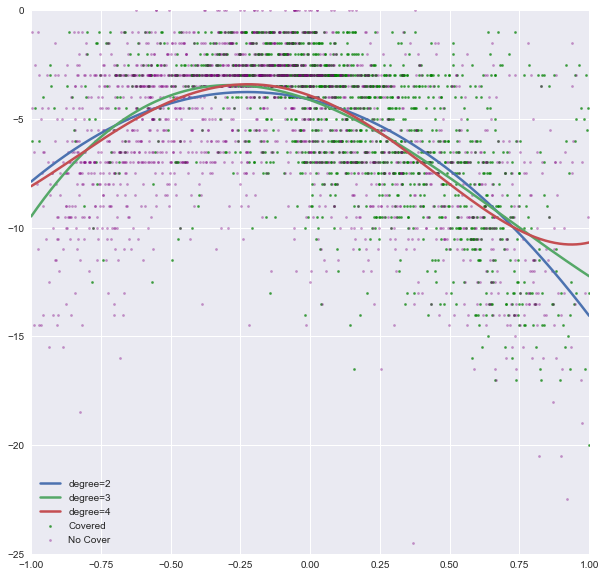

In [48]:
poly_regression(reg_df.exp_win_difference, reg_df.spread_favorite, [2,3,4],-1,1, -25, 0,-1,1)

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     897.4
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          2.22e-177
Time:                        10:23:44   Log-Likelihood:                -9776.1
No. Observations:                3841   AIC:                         1.956e+04
Df Residuals:                    3839   BIC:                         1.957e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.1326      0

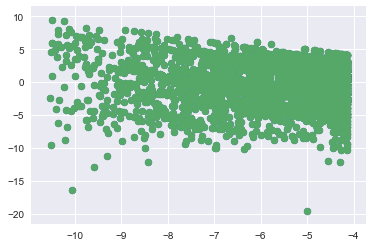

In [49]:
regression_evaluation(reg_df.spread_favorite, (reg_df.exp_win_difference**2))

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     255.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          3.12e-151
Time:                        10:23:45   Log-Likelihood:                -9829.7
No. Observations:                3841   AIC:                         1.967e+04
Df Residuals:                    3837   BIC:                         1.969e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0249      0.069    -87.557      0.0

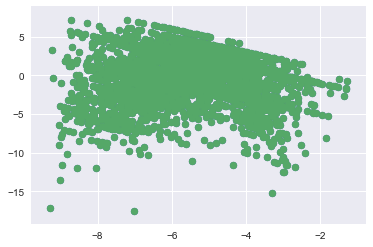

In [50]:
regression_evaluation(reg_df.spread_favorite, reg_df[['last_four_difference', 'exp_win_difference', 'favorite_covered']].values)

# WEEK- REJECTED LOW PREDICTABILITY

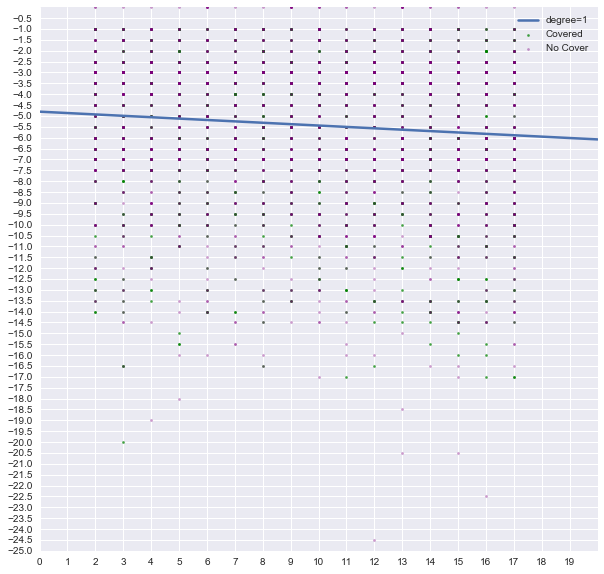

In [51]:
poly_regression(reg_df.schedule_week, reg_df.spread_favorite, [1],0,20, -25, 0,0,25)
plt.yticks(np.arange(-25,0,.5))
plt.xticks(np.arange(0,20,1));

In [52]:
log_log_regression_evaluation(week5_df.spread_favorite, week5_df[['home_favorite', 'exp_win_difference','last_four_difference']])

NameError: name 'log_log_regression_evaluation' is not defined

In [53]:
log_log_regression_evaluation(week5_df.over_under_line, week5_df[['weather_temperature', 'weather_wind_mph','weather_humidity', 'total_ppg', 'total_points_against']])

NameError: name 'log_log_regression_evaluation' is not defined

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



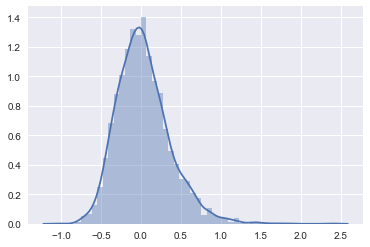

In [54]:
#log-log
y = .6648+.0326*np.log(week5_df.weather_temperature+1)-.0139*np.log(week5_df.weather_wind_mph+1)-.0118*np.log(week5_df.weather_humidity+1)+.4627*np.log(week5_df.total_ppg+1)+.3439*np.log(week5_df.total_points_against+1)
diff = y - np.log(week5_df.point_total+1)
sns.distplot(diff)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



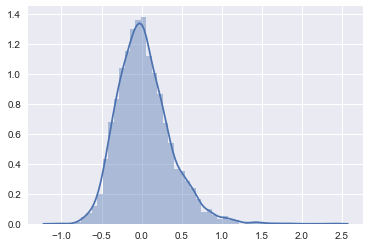

In [55]:
#log-linear
y = 3.0086+.0006*(week5_df.weather_temperature)-.0028*(week5_df.weather_wind_mph)-.0003*(week5_df.weather_humidity)+.0103*(week5_df.total_ppg)+.0074*(week5_df.total_points_against)
diff = y - np.log(week5_df.point_total+1)
sns.distplot(diff)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



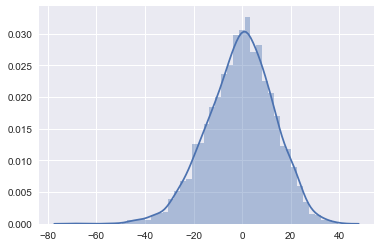

In [56]:
#linear
y = 8.5852+.0298*(week5_df.weather_temperature)-.113*(week5_df.weather_wind_mph)-.0103*(week5_df.weather_humidity)+.4529*(week5_df.total_ppg)+.3294*(week5_df.total_points_against)
diff = y - week5_df.point_total
sns.distplot(diff)

ou_df = week5_df[['over_under_line','over_under_result','point_total']]

In [57]:
y = 8.5852+.0298*(week5_df.weather_temperature)-.113*(week5_df.weather_wind_mph)-.0103*(week5_df.weather_humidity)+.4529*(week5_df.total_ppg)+.3294*(week5_df.total_points_against)
ou_df = week5_df[['over_under_line','over_under_result','point_total']]

ou_df['prediction']= y
ou_df['over_under_result'] = np.where(ou_df['over_under_result']=='over', 1, 0)

ou_df['good_prediction']=np.where((ou_df['prediction']<ou_df['over_under_line']) & (ou_df['over_under_result']==0),1,0)
ou_df['good_prediction']=np.where((ou_df['prediction']>ou_df['over_under_line']) & (ou_df['over_under_result']==1),1,ou_df['good_prediction'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

In [58]:
np.sum(ou_df.good_prediction)/len(ou_df)

0.5090032154340836

## Predict home and way point totals, from there we can derive spread and o/u

In [59]:
pd.set_option('display.max_columns', 1000)
week5_df.corr()

,schedule_season,schedule_week,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,weather_humidity,score_home,score_away,point_total,score_difference,home_favorite,favorite_covered,home_wins,home_losses,home_ties,away_wins,away_losses,away_ties,home_points_for,home_points_against,away_points_for,away_points_against,h_games,a_games,home_win_pct,away_win_pct,win_pct_diff,h_ppg,h_papg,a_ppg,a_papg,home_pt_diff_pg,away_pt_diff_pg,pt_diff_pg,home_exp_win_pct,away_exp_win_pct,home_win_pct_last_4,away_win_pct_last_4,exp_win_difference,total_ppg,total_points_against,last_four_difference
schedule_season,1.000000,-0.001999,0.014470,0.331189,0.113061,-0.222340,-0.068401,0.039526,0.056750,0.070170,-0.011471,-0.068842,-0.036980,0.007593,0.003046,0.038746,0.002516,0.006730,0.048256,0.077455,0.079802,0.077693,0.081646,0.009292,0.008514,0.000462,-0.000687,0.000817,0.140759,0.158937,0.141551,0.159303,-0.000111,0.000130,-0.000173,0.001820,0.002821,-0.000708,-0.005887,-0.000722,0.195429,0.216731,0.003711
schedule_week,-0.001999,1.000000,-0.087865,-0.044495,-0.350360,0.014006,0.078472,-0.010523,-0.036356,-0.034099,0.017564,-0.013050,-0.037197,0.637521,0.634086,0.055684,0.633268,0.638734,0.056540,0.848180,0.884070,0.847985,0.884624,0.995689,0.995664,0.006579,-0.016146,0.016157,0.014071,0.003746,0.006345,0.037700,0.007555,-0.019024,0.019090,-0.001600,-0.022643,0.058714,0.046722,0.015033,0.014115,0.028310,0.008483
spread_favorite,0.014470,-0.087865,1.000000,-0.027486,0.058545,-0.002069,0.012550,-0.127483,0.150094,0.015407,-0.190503,-0.180816,0.101509,-0.235556,0.124199,-0.018259,0.141718,-0.256463,0.016740,-0.193011,-0.001021,0.040597,-0.158215,-0.087787,-0.090265,-0.229482,0.264427,-0.351215,-0.226854,0.152066,0.224174,-0.182171,-0.254010,0.270790,-0.376378,-0.262649,0.280093,-0.188394,0.210939,-0.386522,-0.000853,-0.021333,-0.285677
over_under_line,0.331189,-0.044495,-0.027486,1.000000,0.200052,-0.293958,-0.060153,0.204085,0.200516,0.295186,0.003943,-0.059935,-0.073602,0.061377,-0.113090,-0.011009,0.077504,-0.128558,0.030552,0.205775,0.108034,0.202259,0.083786,-0.040586,-0.039625,0.113449,0.136888,-0.016589,0.476907,0.314137,0.472284,0.268349,0.139336,0.164326,-0.018703,0.133886,0.151444,0.100701,0.108494,-0.013078,0.657060,0.396574,-0.005763
weather_temperature,0.113061,-0.350360,0.058545,0.200052,1.000000,-0.412407,-0.049344,-0.001395,0.081567,0.058163,-0.056667,-0.039864,-0.005278,-0.285188,-0.157589,-0.067115,-0.227415,-0.212240,-0.041167,-0.302831,-0.240951,-0.282022,-0.292691,-0.347986,-0.344670,-0.083160,-0.004109,-0.056242,-0.021137,0.130597,0.023390,0.017319,-0.096176,0.005632,-0.072773,-0.091159,0.006171,-0.059127,-0.009876,-0.069138,0.001659,0.100453,-0.035168
weather_wind_mph,-0.222340,0.014006,-0.002069,-0.293958,-0.412407,1.000000,0.010351,-0.085605,-0.111780,-0.143897,0.017243,0.028833,0.004037,0.014824,0.003588,-0.003845,-0.000564,0.017581,-0.015456,-0.029633,-0.051007,-0.016277,-0.000861,0.014308,0.012937,0.010601,-0.013025,0.016800,-0.081852,-0.130357,-0.057832,-0.029991,0.023686,-0.021900,0.032685,0.013226,-0.024048,0.015261,-0.014758,0.026565,-0.096642,-0.108951,0.021473
weather_humidity,-0.068401,0.078472,0.012550,-0.060153,-0.049344,0.010351,1.000000,-0.008048,-0.007527,-0.011364,-0.000415,-0.016670,-0.002997,0.027820,0.073145,0.020731,0.054714,0.043153,0.006452,0.050215,0.064712,0.062391,0.064618,0.079433,0.076630,-0.034114,0.018366,-0.037324,-0.037031,-0.011840,0.006690,-0.013405,-0.018630,0.013060,-0.022710,-0.017950,0.012035,-0.014375,0.015462,-0.021340,-0.020906,-0.017197,-0.021345
score_home,0.039526,-0.010523,-0.127483,0.204085,-0.001395,-0.085605,-0.008048,1.000000,-0.060579,0.689501,0.731667,0.215824,0.188181,0.160061,-0.172340,0.009657,-0.084506,0.074680,0.001498,0.134044,-0.050007,-0.024710,0.053854,-0.009122,-0.007229,0.205545,-0.096077,0.214523,0.267852,-0.092056,-0.026903,0.120858,0.245454,-0.094144,0.243136,0.242847,-0.104899,0.173021,-0.081051,0.247352,0.166139,0.020144,0.181663
score_away,0.

In [60]:
def test_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    
    split = train_test_split(x, y,test_size = 0.25, random_state = 42)
    print(split[0].features)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)
    
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [61]:
test_df = week5_df[week5_df.schedule_season>2010]


In [62]:
test_regression(test_df.a_papg, test_df.score_home, [1,2,3,4],10,35, 10,45)

AttributeError: 'Series' object has no attribute 'features'

<Figure size 720x720 with 0 Axes>

                            OLS Regression Results                            
Dep. Variable:             score_home   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     21.87
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           3.51e-38
Time:                        10:24:10   Log-Likelihood:                -4983.0
No. Observations:                1352   AIC:                             9988.
Df Residuals:                    1341   BIC:                         1.005e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.6861    

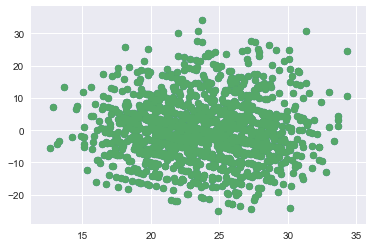

In [63]:
regression_evaluation(test_df.score_home,test_df[['spread_favorite','over_under_line','weather_wind_mph',
                                                  'home_favorite','h_ppg','a_papg','home_exp_win_pct',
                                                 'away_exp_win_pct','home_win_pct_last_4','away_win_pct_last_4']])

In [64]:
def log_linear_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x, np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [65]:
def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max,xfit1, xfit2, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(np.log(x+1), np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']=='over']
        y2 = y[reg_df['over_under_result']=='under']
        x1 = x[reg_df['over_under_result']=='over']
        x2 = x[reg_df['over_under_result']=='under']
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xfit1,xfit2, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

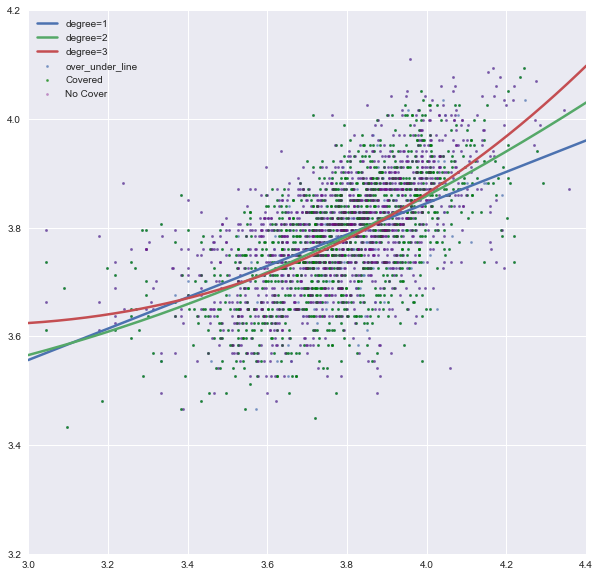

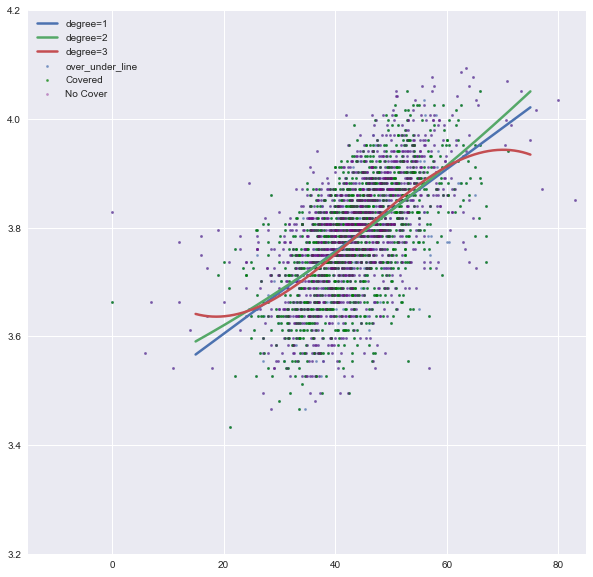

In [66]:
#poly_regression((reg_df.total_ppg), reg_df.over_under_line, [1,2],15,85, 25, 65,10,150)
log_log_regression(reg_df.total_ppg, reg_df.over_under_line, [1,2,3],3,4.4,3.2,4.2,0,5)
log_linear_regression(reg_df.total_ppg, reg_df.over_under_line, [1,2,3],-15,85,3.2,4.2,15,75)#log-linear reg, change logx to x in function

In [67]:
def log_log_regression_evaluation(target, X_list):
    split = train_test_split((np.log(np.abs(X_list)+1)), np.log(np.abs(target)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [68]:
def log_linear_regression_evaluation(target,X_list):
    split = train_test_split(X_list, np.log(np.abs(target)+1))## log-linear eval
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

                            OLS Regression Results                            
Dep. Variable:        spread_favorite   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     510.1
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          4.10e-104
Time:                        10:24:21   Log-Likelihood:                -2067.9
No. Observations:                2880   AIC:                             4140.
Df Residuals:                    2878   BIC:                             4152.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.4023      0

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



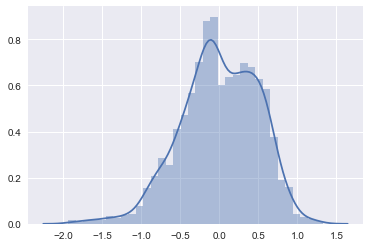

In [69]:
log_log_regression_evaluation(reg_df.spread_favorite, reg_df.exp_win_difference)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



7.375

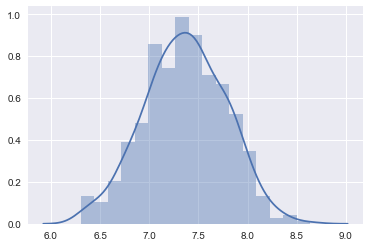

In [70]:
t = [9,9,9,9,9,9,1,4]
sns.distplot(n_samples(t,50,500))
np.sum(t)/len(t)

## all variable over/under log_reg eval

In [71]:
test_df = reg_df[(reg_df.schedule_week>4)]
test_df[test_df.weather_detail=='DOME']
test_df['dome'] = np.where(test_df['weather_detail']=='DOME', 1, 0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [72]:
log_regression_evaluation(test_df.over_under_line, test_df[['dome','weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']].values)
regression_evaluation(test_df.over_under_line, test_df[['dome','weather_wind_mph', 'weather_humidity', 'total_points_against', 'total_ppg','weather_temperature']].values)


NameError: name 'log_regression_evaluation' is not defined

                            OLS Regression Results                            
Dep. Variable:        over_under_line   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     2182.
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        10:24:24   Log-Likelihood:                -10540.
No. Observations:                3841   AIC:                         2.108e+04
Df Residuals:                    3839   BIC:                         2.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2891      0.325     87.052      0.0

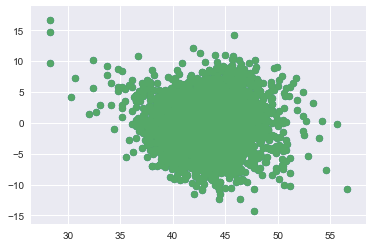

In [73]:
regression_evaluation(reg_df.over_under_line, reg_df.total_ppg)

In [74]:
log_regression_evaluation(reg_df.over_under_line, reg_df.total_ppg)

NameError: name 'log_regression_evaluation' is not defined

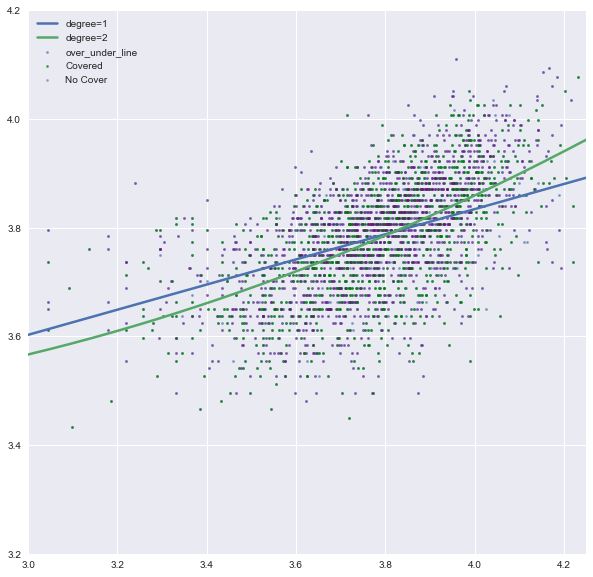

In [75]:
log_log_regression(reg_df.total_ppg,reg_df.over_under_line,[1,2],3,4.25,3.2,4.2,0,5)